In [27]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import (
    mean_squared_error,
    explained_variance_score,
    mean_absolute_error,
    r2_score,
)
from sklearn.preprocessing import MinMaxScaler
import pickle
import matplotlib.pyplot as plt
from incremental_trees.models.regression.streaming_rfr import StreamingRFR


In [28]:
def randomForestRegressor(X, y):
    
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.05, random_state=42
    )

    # n = y.shape[0]
    # lim = 15
    # X_train, X_test, y_train, y_test = X.iloc[:n-lim], X.iloc[n-lim:], y.iloc[:n-lim], y.iloc[n-lim:]
    regr = StreamingRFR(
        n_estimators=100,
        criterion="mse",
        max_depth=100,
        min_samples_leaf=2,
        bootstrap=True,
        warm_start=False,
    )
    print(f"Entrenando {y.name}")
    regr.partial_fit(X_train, y_train)
    predicts = regr.predict(X_test)

    print("Parameters:", regr.get_params())
    # print("Mean Absolute Error:", mean_absolute_error(y_test, predicts))
    print("Mean Squared Error:", mean_squared_error(y_test, predicts))
    # print("Root Mean Squared Error:", np.sqrt(mean_squared_error(y_test, predicts)))
    # print("Mean Absolute Percentage Error:", np.mean(np.abs((y_test, predicts)) * 100))
    print("R2:", regr.score(X_test, y_test))  # , r2_score(y_test, predicts))

    return regr, regr.predict(X)

In [29]:
def fit_rf_e(df, pkl_file):
    X = df[
        [
            "susceptibles_t_6", "infectados_t_7", "decesos_t_5", "decesos_t_7"
        ]
    ]
    y = df["expuestos"]
    model, y_predict = randomForestRegressor(X, y)
    pickle.dump(model, open(pkl_file, 'wb'))

    df["expuestos_predicho"] = pd.Series(y_predict)
    return df, model


## Entrenar modelo con los datos hasta Julio

In [30]:
# Leer datos
data = "./data/seird_constantes_dia_colombia_dependencia_cruzada_emulador.csv"
df_1 = pd.read_csv(data)
df = df_1.drop(columns=['fecha'])

# Normalizar datos
scaler = MinMaxScaler()
scaled_values = scaler.fit_transform(df)
df.loc[:,:] = scaled_values
df['fecha'] = df_1['fecha']

# Entrenar modelo con los datos hasta Julio
df_julio = df.iloc[:141]
df_julio, model = fit_rf_e(df_julio, "./pkl/e_col_emulador.pkl")
df_julio[["fecha", "expuestos", "expuestos_predicho"]]

Entrenando expuestos
Parameters: {'bootstrap': True, 'criterion': 'mse', 'dask_feeding': True, 'max_depth': 100, 'max_features': 'auto', 'max_leaf_nodes': None, 'max_n_estimators': 10, 'min_impurity_decrease': 0.0, 'min_impurity_split': None, 'min_samples_leaf': 2, 'min_samples_split': 2, 'min_weight_fraction_leaf': 0.0, 'n_estimators': 2, 'n_estimators_per_chunk': 1, 'n_jobs': None, 'oob_score': False, 'random_state': None, 'spf_n_fits': 100, 'spf_sample_prop': 0.1, 'verbose': 0, 'warm_start': True}
Mean Squared Error: 0.0026408794802326033
R2: 0.9468145997634312


,fecha,expuestos,expuestos_predicho
0,2020-03-13,0.002501,0.007869
1,2020-03-14,0.008039,0.007869
2,2020-03-15,0.013964,0.007869
3,2020-03-16,0.004201,0.007869
4,2020-03-17,0.001603,0.007869
...,...,...,...
136,2020-07-27,0.729891,0.796034
137,2020-07-28,0.750899,0.796034
138,2020-07-29,0.775646,0.796034
139,2020-07-30,0.840830,0.796034


## Comparando datos reales vs datos predichos hasta julio

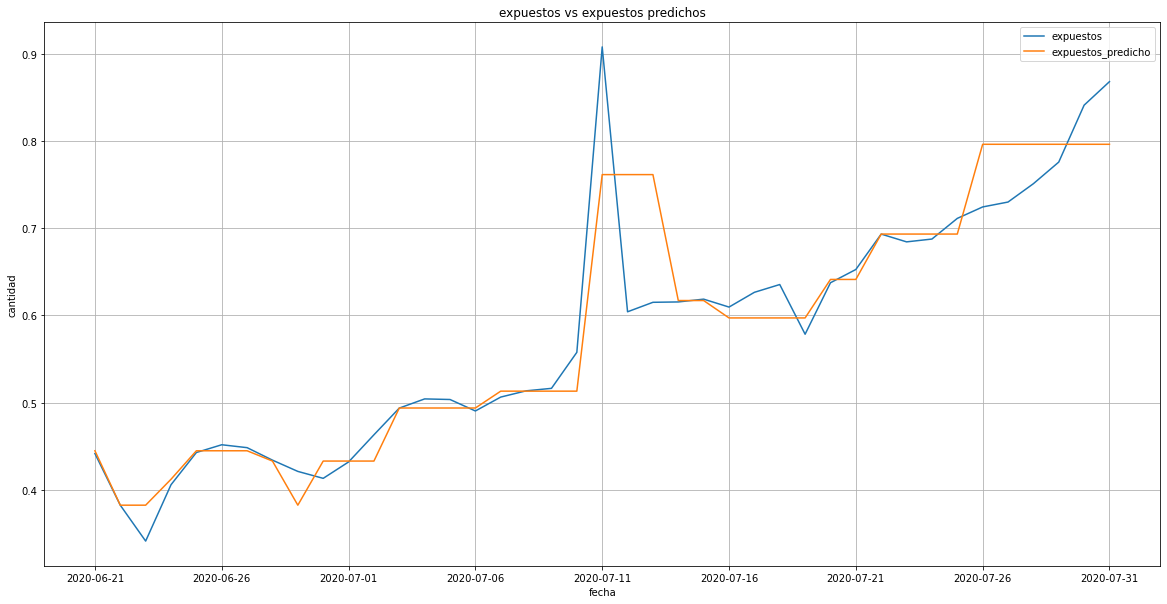

In [31]:
df_julio.iloc[100:].plot(
    x="fecha",
    y=["expuestos", "expuestos_predicho"],
    kind="line",
    figsize=(20, 10),
    grid=True,
    legend=True,
    loglog=False,
    title="expuestos vs expuestos predichos",
)
plt.ylabel("cantidad")
plt.show()

In [32]:
print("R2", r2_score(df_julio.iloc[100:]["expuestos"], df_julio.iloc[100:]["expuestos_predicho"]))
print("MSE:", mean_squared_error(df_julio.iloc[130:183]["expuestos"], df_julio.iloc[130:183]["expuestos_predicho"]))

R2 0.8772450049713385
MSE: 0.0017905033253825002


## Simulador aprendizaje incremental: sin reentrenar modelo cada 7 dias (para comparar la mejoria)

In [33]:
df["expuestos_predicho"] = df_julio["expuestos_predicho"]
# df.iloc[135:145][["fecha", "infectados", "infectados_predicho"]]

In [34]:
periodicidad = 7
n_inicial = df_julio.shape[0] + periodicidad
n_final = df.shape[0]
for i in range(n_inicial, n_final, periodicidad):
    y = df.iloc[i-periodicidad : i]["expuestos"]
    X = df.iloc[i-periodicidad : i][
        [
            "susceptibles_t_6", "infectados_t_7", "decesos_t_5", "decesos_t_7"
        ]
    ]

    # Reentrenamiento
    #model.partial_fit(X, y)

    # Predict
    y_predict_ = model.predict(X)

    # Guardar en el df datos predichos
    for j in range(periodicidad):
        df.loc[i-periodicidad+j, "expuestos_predicho"] = y_predict_[j]

    print(i-periodicidad, i)
    # print(df.iloc[i-periodicidad : i][["fecha", "infectados", "infectados_predicho"]])
    # print("-----------------------------------------------------")

141 148
148 155
155 162
162 169
169 176
176 183


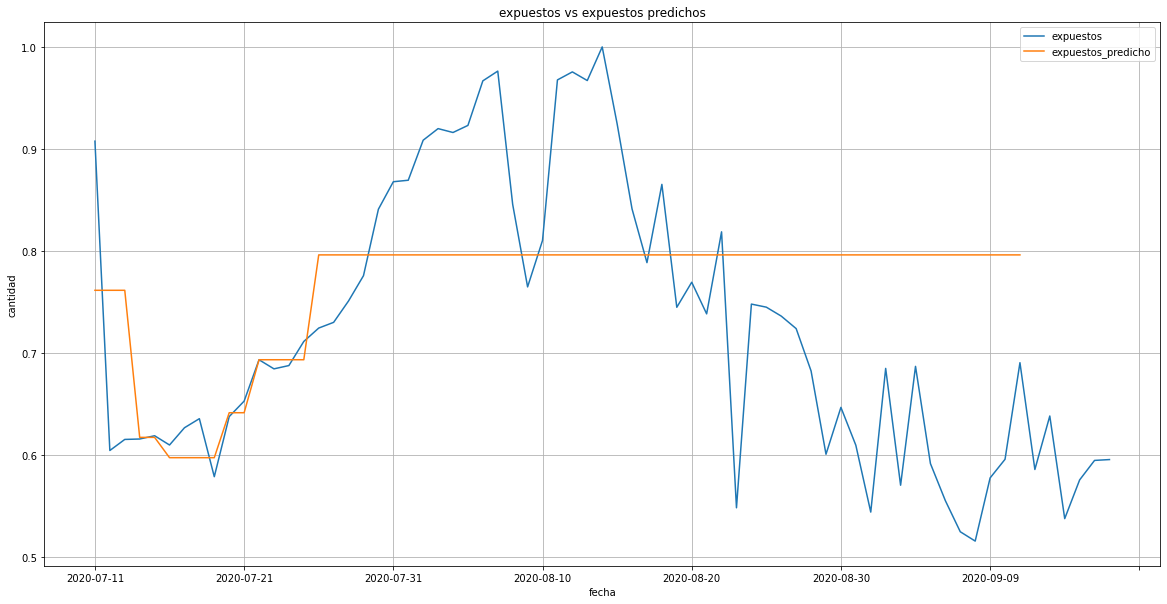

In [35]:
df.iloc[120:].plot(
    x="fecha",
    y=["expuestos", "expuestos_predicho"],
    kind="line",
    figsize=(20, 10),
    grid=True,
    legend=True,
    loglog=False,
    title="expuestos vs expuestos predichos",
)
plt.ylabel("cantidad")
plt.show()

In [36]:
print("R2", r2_score(df.iloc[130:183]["expuestos"], df.iloc[130:183]["expuestos_predicho"]))
print("MSE:", mean_squared_error(df.iloc[130:183]["expuestos"], df.iloc[130:183]["expuestos_predicho"]))

R2 -0.03035600584294662
MSE: 0.01860773484751061


## Simulador aprendizaje incremental: reentrenar modelo cada 7 dias

In [37]:
periodicidad = 7
n_inicial = df_julio.shape[0] + periodicidad
n_final = df.shape[0] + 1
for i in range(n_inicial, n_final, periodicidad):
    y = df.iloc[i-periodicidad : i]["expuestos"]
    X = df.iloc[i-periodicidad : i][
        [
            "susceptibles_t_6", "infectados_t_7", "decesos_t_5", "decesos_t_7"
        ]
    ]

    # Reentrenamiento
    model.partial_fit(X, y)

    # Predict
    y_predict_ = model.predict(X)

    # Guardar en el df datos predichos
    for j in range(periodicidad):
        df.loc[i-periodicidad+j, "expuestos_predicho"] = y_predict_[j]

    # print(df.iloc[i-periodicidad : i][["fecha", "infectados", "infectados_predicho"]])
    # print("-----------------------------------------------------")

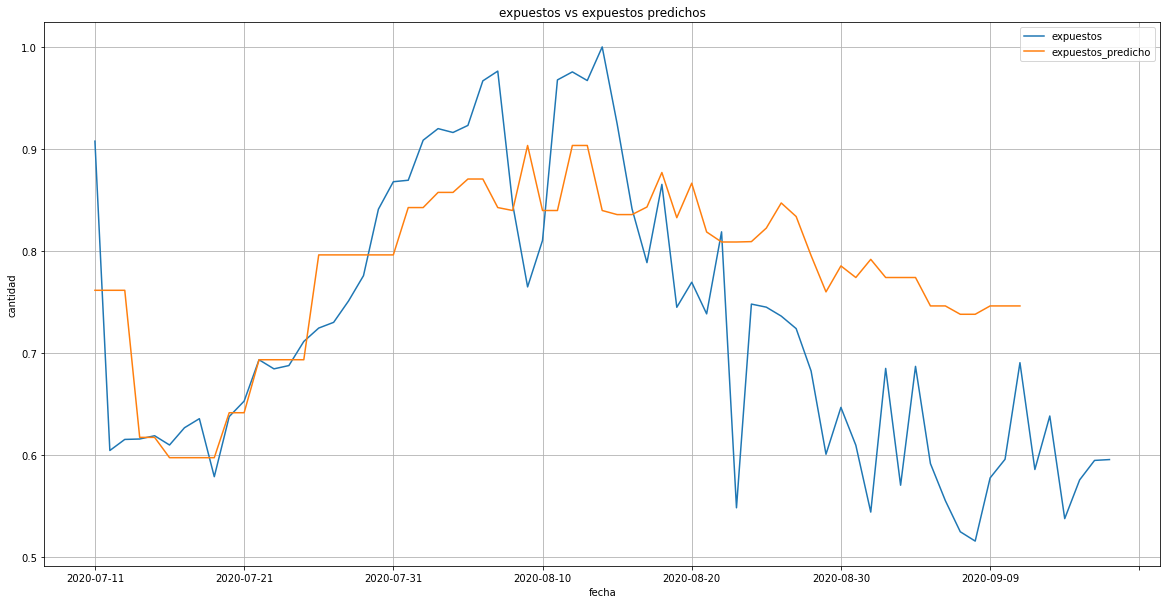

In [38]:
df.iloc[120:].plot(
    x="fecha",
    y=["expuestos", "expuestos_predicho"],
    kind="line",
    figsize=(20, 10),
    grid=True,
    legend=True,
    loglog=False,
    title="expuestos vs expuestos predichos",
)
plt.ylabel("cantidad")
plt.show()

In [39]:
print("R2", r2_score(df.iloc[130:183]["expuestos"], df.iloc[130:183]["expuestos_predicho"]))
print("MSE:", mean_squared_error(df.iloc[130:183]["expuestos"], df.iloc[130:183]["expuestos_predicho"]))

R2 0.2865411420984002
MSE: 0.012884724480816304
